# Cross Model Validation (i.e. Double cross validation)

## What is Cross-Model Validation?
* **Cross-Model Validation** compares the performance of multiple machine learning models on the same dataset.
* It ensures that the selected model is the best fit by evaluating different models in the same evaluation metric

## Why use Cross-Model Validation?
* **Model Comparison:** Helps in selecting the most effective model for a case
* **Evaluation Consistency:** All models are evaluated on the same dataset and conditions
* **Informed Decision:** Ensures the model chosen is the one that generalizes the best

# What is Double Cross Validation?
* Combines two nested cross-validation loops.
    * **Outer loop**: Used for model evaluation
    * **Inner loop**: Used for hyperparameter tuning.

* Allows evaluation of multiple models which are hyperparameter tuned using inner cross validation.

# Steps in Cross-Model Validation

1. Outer Cross-validation: Split data into training and test (Validation) sets.
2. Inner Cross-validation: Tune model hyperparameters within the training data of the outer fold.
3. Evaluation: test the model on the outer test fold after tuning.


# Example on prediction of output power by different models

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# Generate synthetic dataset
np.random.seed(50)
n_samples = 300

flow_rate = np.random.uniform(50, 300, n_samples)
head = np.random.uniform(30, 80, n_samples)
efficiency = np.random.uniform(0.85, 0.95, n_samples)

rho = 1000
g = 9.81
power_output = efficiency * rho * g * flow_rate * head / 1e6  # MW

df = pd.DataFrame({
    'FlowRate': flow_rate,
    'Head': head,
    'Efficiency': efficiency,
    'PowerOutput': power_output
})

X = df[['FlowRate', 'Head', 'Efficiency']]
y = df['PowerOutput']


In [3]:
# Define models and hyperparameter grids
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (
        RandomForestRegressor(random_state=42),
        {'n_estimators': [50, 100], 'max_depth': [None, 10]}
    ),
    'SVR_rbf': (
        SVR(kernel='rbf'),
        {'C': [100, 1000], 'epsilon': [0.1, 1], 'gamma': [0.01, 0.1]}
    ),
    'SVR_Polynomial': (
        SVR(kernel='poly'),
        {'degree': [2, 3], 'C': [1, 10], 'coef0': [0, 1]}
    ),
    'KNN': (
        KNeighborsRegressor(),
        {'n_neighbors': [3, 5, 7]}
    )
}

In [4]:
# Cross-validation setup
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

results = {}

# Double Cross-Validation
for model_name, (model, param_grid) in models.items():
    print(f"Evaluating {model_name}...")

    mae_scores = []
    r2_scores = []
    y_actual_all = []
    y_pred_all = []

    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner loop: hyperparameter tuning (if applicable)
        if param_grid:
            search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='neg_mean_absolute_error', n_jobs=-1)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
        else:
            best_model = model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)

        # Store predictions
        y_actual_all.extend(y_test)
        y_pred_all.extend(y_pred)

        # Store metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mae_scores.append(mae)
        r2_scores.append(r2)

    # Save results with predictions
    results[model_name] = {
        'MAE (Mean ± Std)': f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}",
        'R² (Mean ± Std)': f"{np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}",
        'y_actual': np.array(y_actual_all),
        'y_pred': np.array(y_pred_all)
    }


# Display results
results_df = pd.DataFrame(results).T
print(results_df)


Evaluating Linear Regression...
Evaluating Random Forest...
Evaluating SVR_rbf...
Evaluating SVR_Polynomial...
Evaluating KNN...
                  MAE (Mean ± Std)  R² (Mean ± Std)  \
Linear Regression  6.9892 ± 0.8117  0.9606 ± 0.0062   
Random Forest      4.0415 ± 0.3172  0.9858 ± 0.0041   
SVR_rbf            4.7672 ± 0.8046  0.9747 ± 0.0082   
SVR_Polynomial     2.4623 ± 0.2279  0.9949 ± 0.0012   
KNN                4.6865 ± 0.6190  0.9811 ± 0.0054   

                                                            y_actual  \
Linear Regression  [128.38596263910156, 143.8703206241248, 35.111...   
Random Forest      [128.38596263910156, 143.8703206241248, 35.111...   
SVR_rbf            [128.38596263910156, 143.8703206241248, 35.111...   
SVR_Polynomial     [128.38596263910156, 143.8703206241248, 35.111...   
KNN                [128.38596263910156, 143.8703206241248, 35.111...   

                                                              y_pred  
Linear Regression  [138.739151462359

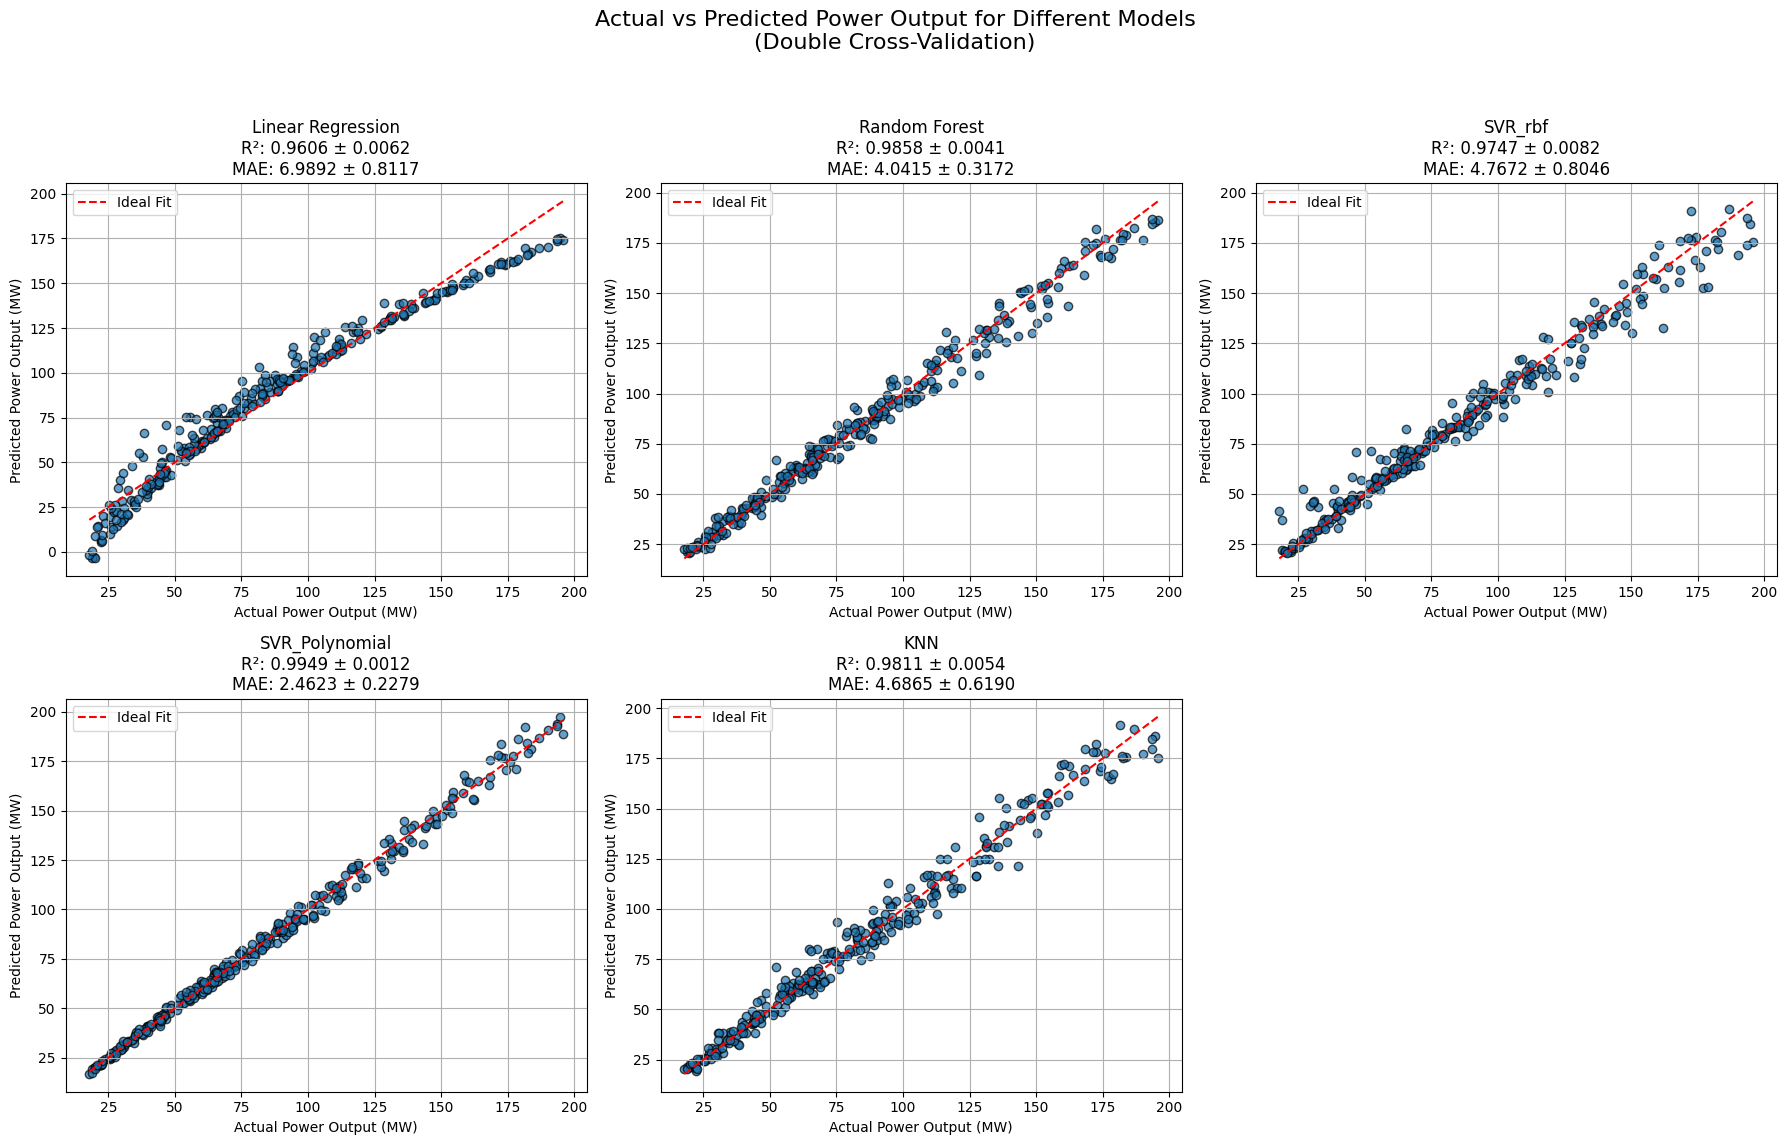

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

for i, (name, res) in enumerate(results.items()):
    y_actual = res['y_actual']
    y_pred = res['y_pred']

    plt.subplot(2, 3, i + 1)
    plt.scatter(y_actual, y_pred, alpha=0.7, edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()],
             'r--', label='Ideal Fit')

    plt.xlabel("Actual Power Output (MW)")
    plt.ylabel("Predicted Power Output (MW)")
    plt.title(f"{name}\nR²: {res['R² (Mean ± Std)']}\nMAE: {res['MAE (Mean ± Std)']}")
    plt.legend()
    plt.grid(True)

plt.suptitle("Actual vs Predicted Power Output for Different Models\n(Double Cross-Validation)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




## Key Insights

- **SVR with Polynomial Kernel** outperformed all other models with an R² of **0.995**, closely modeling the non-linear physics-based relationship between input and output.
- **Random Forest** and **KNN** also showed strong performance, both capturing non-linearity effectively with minimal tuning.
- **Linear Regression**, while interpretable, underperformed compared to nonlinear models—highlighting the limits of assuming a purely linear relationship.
- **SVR with RBF Kernel**, after tuning, significantly improved its performance compared to default settings. (in default setting, the R2 was around 0.63)


# Recommendations in Cross-Model Validation

- Use Consistent Evaluation
    - Same data splits and same metrics for all models.

- Consider Trade-offs
    - Accuracy vs Interpretability (e.g., Random Forest vs Decision Tree)
    - Training Time vs Performance (e.g., Logistic Regression is faster)
- Use Cross-Validation Internally
    - Even during cross-model validation, we can apply **cross-validation** to each model for more robust comparisons.
- Don't Rely on Accuracy Alone
    - Consider precision, recall, or F1-score, especially for **imbalanced datasets**.

# Advantages of Cross-Model Validation
* Avoids Overfitting
* More Reliable Model Comparison
* Robust Performance Estimate

# Conclusion

- Cross-Model Validation ensures fair, reliable and robust evaluation of multiple models.
- Helps choose the model that generalizes best to new data while minimizing the risk of overfitting.
- Enables informed model selection based on both performance and constraints.
- it is valuable in situations where we need to select the best model for the data and avoid any biased evaluations

# Sources

https://statics.teams.cdn.office.net/evergreen-assets/safelinks/2/atp-safelinks.html

Anderssen, E., Dyrstad, K., Westad, F., & Martens, H. (2006). Reducing over-optimism in variable selection by cross-model validation. Chemometrics and intelligent laboratory systems, 84(1-2), 69-74.

Westad, F. (2021). A retrospective look at cross model validation and its applicability in vibrational spectroscopy. Spectrochimica Acta Part A: Molecular and Biomolecular Spectroscopy, 255, 119676.

## Illustration to demonstarte need for cross validation

In [17]:
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib.pyplot as plt

# without test set (train & test with same data)
y_predict = LinearRegression().fit(X, y).predict(X)

mae_same = mean_absolute_error(y, y_predict)
r2_same = r2_score(y, y_predict)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_predict_train = LinearRegression().fit(X_train, y_train).predict(X_train)
y_predict_test = LinearRegression().fit(X_train, y_train).predict(X_test)

mae_test_split = mean_absolute_error(y_test, y_predict_test)
r2_test_split = r2_score(y_test, y_predict_test)

cv_results = cross_validate(
            LinearRegression(),
            X, y, cv=5,
            scoring=['neg_mean_absolute_error', 'r2'])

mae_cv = -cv_results['test_neg_mean_absolute_error'].mean()
r2_cv = cv_results['test_r2'].mean()

print('Same Train test')
print(f'R2 score:{r2_same:.4f}')
print(f'MAE score:{ mae_same:.4f}')
print('-'*20)
print('Train/test split')
print(f'R2 score:{r2_test_split:.4f}')
print(f'MAE score:{ mae_test_split:.4f}')
print('-'*20)
print('Cross-validation')
print(f'R2 score:{r2_cv:.4f}')
print(f'MAE score:{ mae_cv:.4f}')

Same Train test
R2 score:0.9621
MAE score:6.8876
--------------------
Train/test split
R2 score:0.9641
MAE score:6.4066
--------------------
Cross-validation
R2 score:0.9596
MAE score:6.9933


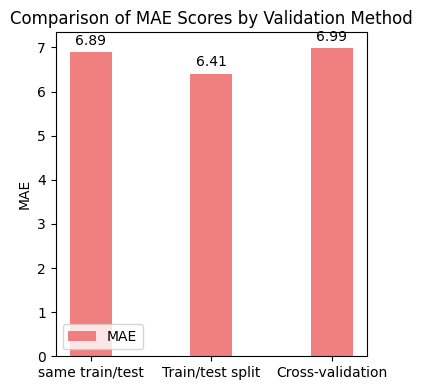

In [24]:
# Bar plot for comparison of MAE scores by Validation Method
methods = ['same train/test', 'Train/test split', 'Cross-validation']
mae_scores = [mae_same, mae_test_split, mae_cv]

x = np.arange(len(methods)) # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(4,4))

rects = ax.bar(x, mae_scores, width, label='MAE', color='lightcoral')


ax.set_ylabel('MAE')
ax.set_title('Comparison of MAE Scores by Validation Method')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

# for value labels on top of the bars
def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.tight_layout()
plt.show()

In [27]:
models = { 'Linear Regression': (LinearRegression(), {}),
          'Random Forest': (
              RandomForestRegressor(random_state=42),
               {'n_estimators': [50, 100], 'max_depth': [None, 10]}
               ),
           'SVR_rbf': ( SVR(kernel='rbf'),
            {'C': [100, 1000], 'epsilon': [0.1, 1], 'gamma': [0.01, 0.1]}
              ),
           'SVR_Polynomial':
            ( SVR(kernel='poly'), {'degree': [2, 3], 'C': [1, 10], 'coef0': [0, 1]}
             ),
           'KNN': ( KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}
                   ) }


# --- Setup ---
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

results = {}
fold_details = []  # store per-fold results for later plotting

# --- Double Cross-Validation ---
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    fold_result = {}
    best_model_name, best_mae, best_params = None, float("inf"), {}

    for model_name, (model, param_grid) in models.items():
        # Inner loop: hyperparameter tuning
        if param_grid:
            search = GridSearchCV(model, param_grid, cv=inner_cv,
                                  scoring="neg_mean_absolute_error", n_jobs=-1)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            current_params = search.best_params_
        else:
            best_model = model.fit(X_train, y_train)
            current_params = {}

        y_pred = best_model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save per-model results for this fold
        fold_result[model_name] = {
            "MAE": mae,
            "R2": r2,
            "Params": current_params,
            "y_true": y_test.values,
            "y_pred": y_pred
        }

        # Track best model per fold
        if mae < best_mae:
            best_mae = mae
            best_model_name = model_name
            best_params = current_params

    # Store fold results
    fold_details.append({"Fold": fold + 1,
                         "Results": fold_result,
                         "Best_Model": best_model_name,
                         "Best_Params": best_params})

# --- Aggregate results ---
for model_name in models.keys():
    mae_scores = [fd["Results"][model_name]["MAE"] for fd in fold_details]
    r2_scores = [fd["Results"][model_name]["R2"] for fd in fold_details]
    y_actual_all = np.concatenate([fd["Results"][model_name]["y_true"] for fd in fold_details])
    y_pred_all = np.concatenate([fd["Results"][model_name]["y_pred"] for fd in fold_details])

    results[model_name] = {
        "MAE (Mean ± Std)": f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}",
        "R² (Mean ± Std)": f"{np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}",
        "y_actual": y_actual_all,
        "y_pred": y_pred_all
    }

# --- Display summary table ---
results_df = pd.DataFrame(results).T
display(results_df.iloc[:, 0:2])

,MAE (Mean ± Std),R² (Mean ± Std)
Linear Regression,6.9892 ± 0.8117,0.9606 ± 0.0062
Random Forest,4.0415 ± 0.3172,0.9858 ± 0.0041
SVR_rbf,4.7672 ± 0.8046,0.9747 ± 0.0082
SVR_Polynomial,2.4623 ± 0.2279,0.9949 ± 0.0012
KNN,4.6865 ± 0.6190,0.9811 ± 0.0054


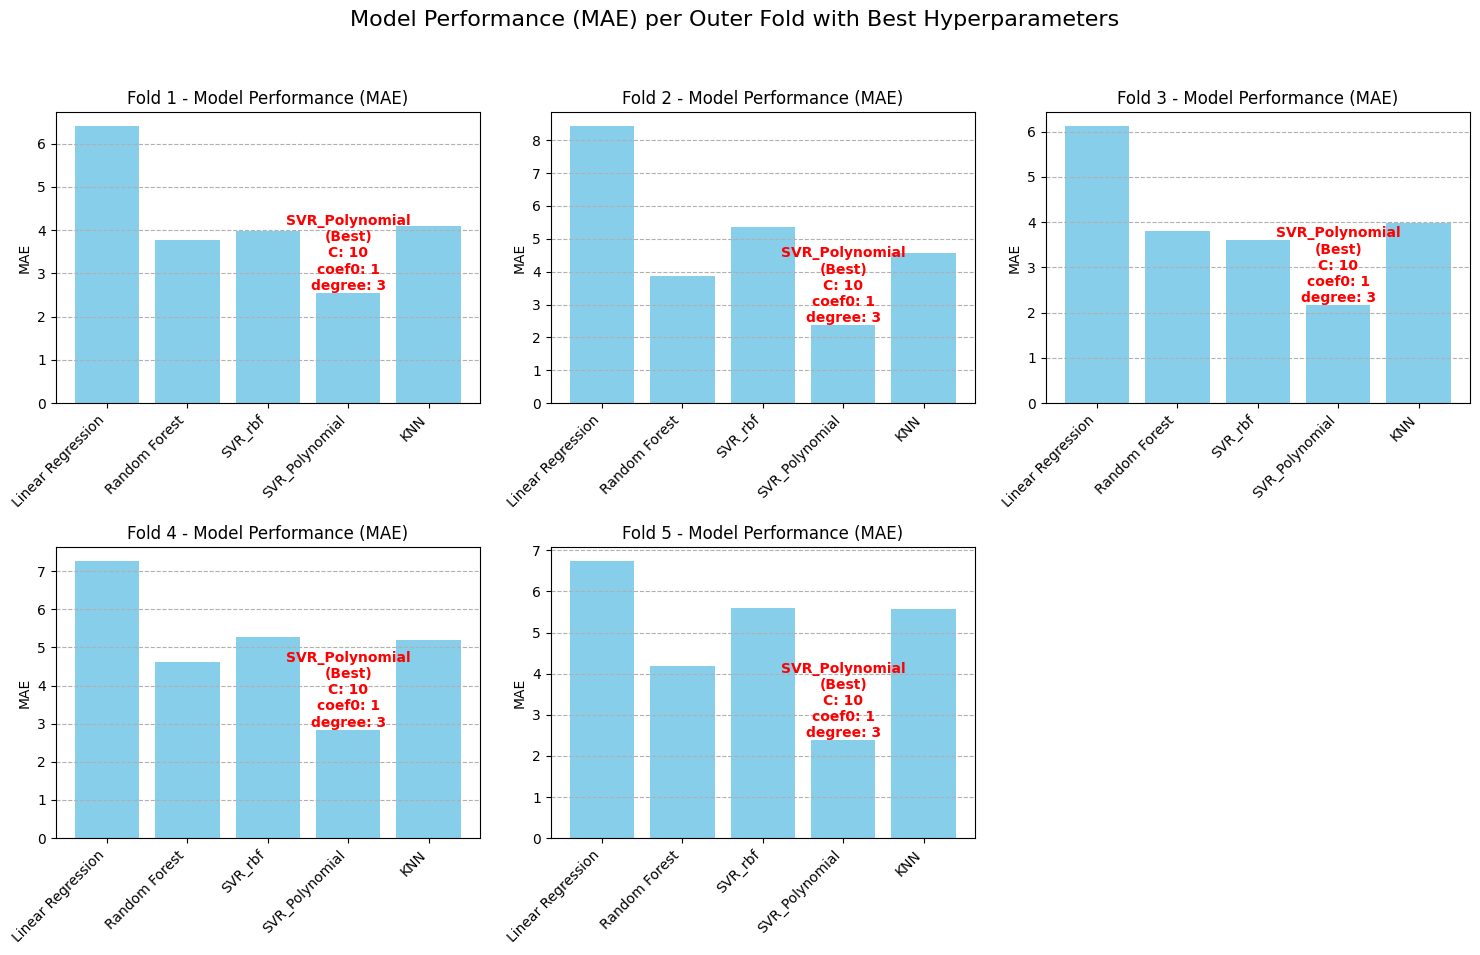

In [28]:
# --- Plot per-fold performance ---
plt.figure(figsize=(15, 10))

for i, fd in enumerate(fold_details):
    plt.subplot(2, 3, i + 1)
    model_names = list(fd["Results"].keys())
    mae_scores = [fd["Results"][m]["MAE"] for m in model_names]

    bars = plt.bar(model_names, mae_scores, color="skyblue")
    plt.ylabel("MAE")
    plt.title(f"Fold {fd['Fold']} - Model Performance (MAE)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--")

    # Annotate best model
    best_model = fd["Best_Model"]
    best_params = fd["Best_Params"]
    for j, bar in enumerate(bars):
        model_name = model_names[j]
        if model_name == best_model:
            param_text = "\n".join([f"{k}: {v}" for k, v in best_params.items()])
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                     f"{best_model}\n(Best)\n{param_text}",
                     va="bottom", ha="center", color="red", fontweight="bold")

plt.suptitle("Model Performance (MAE) per Outer Fold with Best Hyperparameters", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Visulaizing entire inner and outer loops, added new models removed svr poly just to show some difference between models

In [36]:
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (
        RandomForestRegressor(random_state=42),
        {'n_estimators': [50, 100], 'max_depth': [None, 10]}
    ),
    'Gradient Boosting': (
        GradientBoostingRegressor(random_state=42),
        {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 5]}
    ),
    'SVR_rbf': (
        SVR(kernel='rbf'),
        {'C': [100, 1000], 'epsilon': [0.1, 1], 'gamma': [0.01, 0.1]}
    ),
    # 'SVR_poly': (
    #     SVR(kernel='poly'),
    #     {'degree': [2, 3], 'C': [1, 10], 'coef0': [0, 1]}
    # ),
    'Elastic Net': (
        ElasticNet(random_state=42),
        {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]}
    ),
    'KNN': (
        KNeighborsRegressor(),
        {'n_neighbors': [3, 5, 7]}
    ),
    'Neural Network': (
        MLPRegressor(max_iter=1000, random_state=42),
        {'hidden_layer_sizes': [(50,), (100,), (100, 50)],
         'alpha': [0.0001, 0.001],
         'learning_rate_init': [0.001, 0.01]}
    )
}
# --- Setup ---
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)  # fewer splits for visualization
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

nested_results = []  # store inner + outer results per outer fold

# --- Nested CV ---
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X)):
    X_outer_train, X_outer_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
    y_outer_train, y_outer_test = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

    inner_fold_results = []
    model_selection_scores = {}  # track avg MAE across inner folds for model selection

    for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_outer_train)):
        X_inner_train, X_inner_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[inner_val_idx]
        y_inner_train, y_inner_val = y_outer_train.iloc[inner_train_idx], y_outer_train.iloc[inner_val_idx]

        fold_result = {}
        best_model_name, best_mae, best_params = None, float("inf"), {}

        for model_name, (model, param_grid) in models.items():
            if param_grid:
                search = GridSearchCV(model, param_grid, cv=3,  # shallow CV inside inner to reduce runtime
                                      scoring="neg_mean_absolute_error", n_jobs=-1)
                search.fit(X_inner_train, y_inner_train)
                best_model = search.best_estimator_
                current_params = search.best_params_
            else:
                best_model = model.fit(X_inner_train, y_inner_train)
                current_params = {}

            y_pred = best_model.predict(X_inner_val)
            mae = mean_absolute_error(y_inner_val, y_pred)

            fold_result[model_name] = {"MAE": mae, "Params": current_params}

            # Track average MAE for model selection
            model_selection_scores.setdefault(model_name, []).append(mae)

            if mae < best_mae:
                best_mae = mae
                best_model_name = model_name
                best_params = current_params

        inner_fold_results.append({
            "Inner_Fold": inner_fold + 1,
            "Results": fold_result,
            "Best_Model": best_model_name,
            "Best_Params": best_params
        })

    # Select best model based on mean inner MAE
    avg_maes = {m: np.mean(scores) for m, scores in model_selection_scores.items()}
    selected_model = min(avg_maes, key=avg_maes.get)
    selected_params = None

    # Retrain selected model on full outer train set
    if models[selected_model][1]:
        search = GridSearchCV(models[selected_model][0], models[selected_model][1],
                              cv=inner_cv, scoring="neg_mean_absolute_error", n_jobs=-1)
        search.fit(X_outer_train, y_outer_train)
        final_model = search.best_estimator_
        selected_params = search.best_params_
    else:
        final_model = models[selected_model][0].fit(X_outer_train, y_outer_train)
        selected_params = {}

    y_outer_pred = final_model.predict(X_outer_test)
    outer_mae = mean_absolute_error(y_outer_test, y_outer_pred)
    outer_r2 = r2_score(y_outer_test, y_outer_pred)

    nested_results.append({
        "Outer_Fold": outer_fold + 1,
        "Inner_Results": inner_fold_results,
        "Selected_Model": selected_model,
        "Selected_Params": selected_params,
        "Outer_MAE": outer_mae,
        "Outer_R2": outer_r2
    })

display(nested_results)

[{'Outer_Fold': 1,
  'Inner_Results': [{'Inner_Fold': 1,
    'Results': {'Linear Regression': {'MAE': 8.020028599979941, 'Params': {}},
     'Random Forest': {'MAE': 4.169189193528333,
      'Params': {'max_depth': 10, 'n_estimators': 100}},
     'Gradient Boosting': {'MAE': 3.19826830898427,
      'Params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}},
     'SVR_rbf': {'MAE': 6.873490680508769,
      'Params': {'C': 100, 'epsilon': 0.1, 'gamma': 0.01}},
     'Elastic Net': {'MAE': 8.141211320560508,
      'Params': {'alpha': 0.01, 'l1_ratio': 0.8}},
     'KNN': {'MAE': 4.8445523992890305, 'Params': {'n_neighbors': 3}},
     'Neural Network': {'MAE': 5.551276157816109,
      'Params': {'alpha': 0.001,
       'hidden_layer_sizes': (100,),
       'learning_rate_init': 0.01}}},
    'Best_Model': 'Gradient Boosting',
    'Best_Params': {'learning_rate': 0.1,
     'max_depth': 3,
     'n_estimators': 200}},
   {'Inner_Fold': 2,
    'Results': {'Linear Regression': {'MAE': 6.

/tmp/ipython-input-427888299.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha="right")
/tmp/ipython-input-427888299.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha="right")
/tmp/ipython-input-427888299.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha="right")
/tmp/ipython-input-427888299.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha="right")
/tmp/ipython-input-427888299.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of

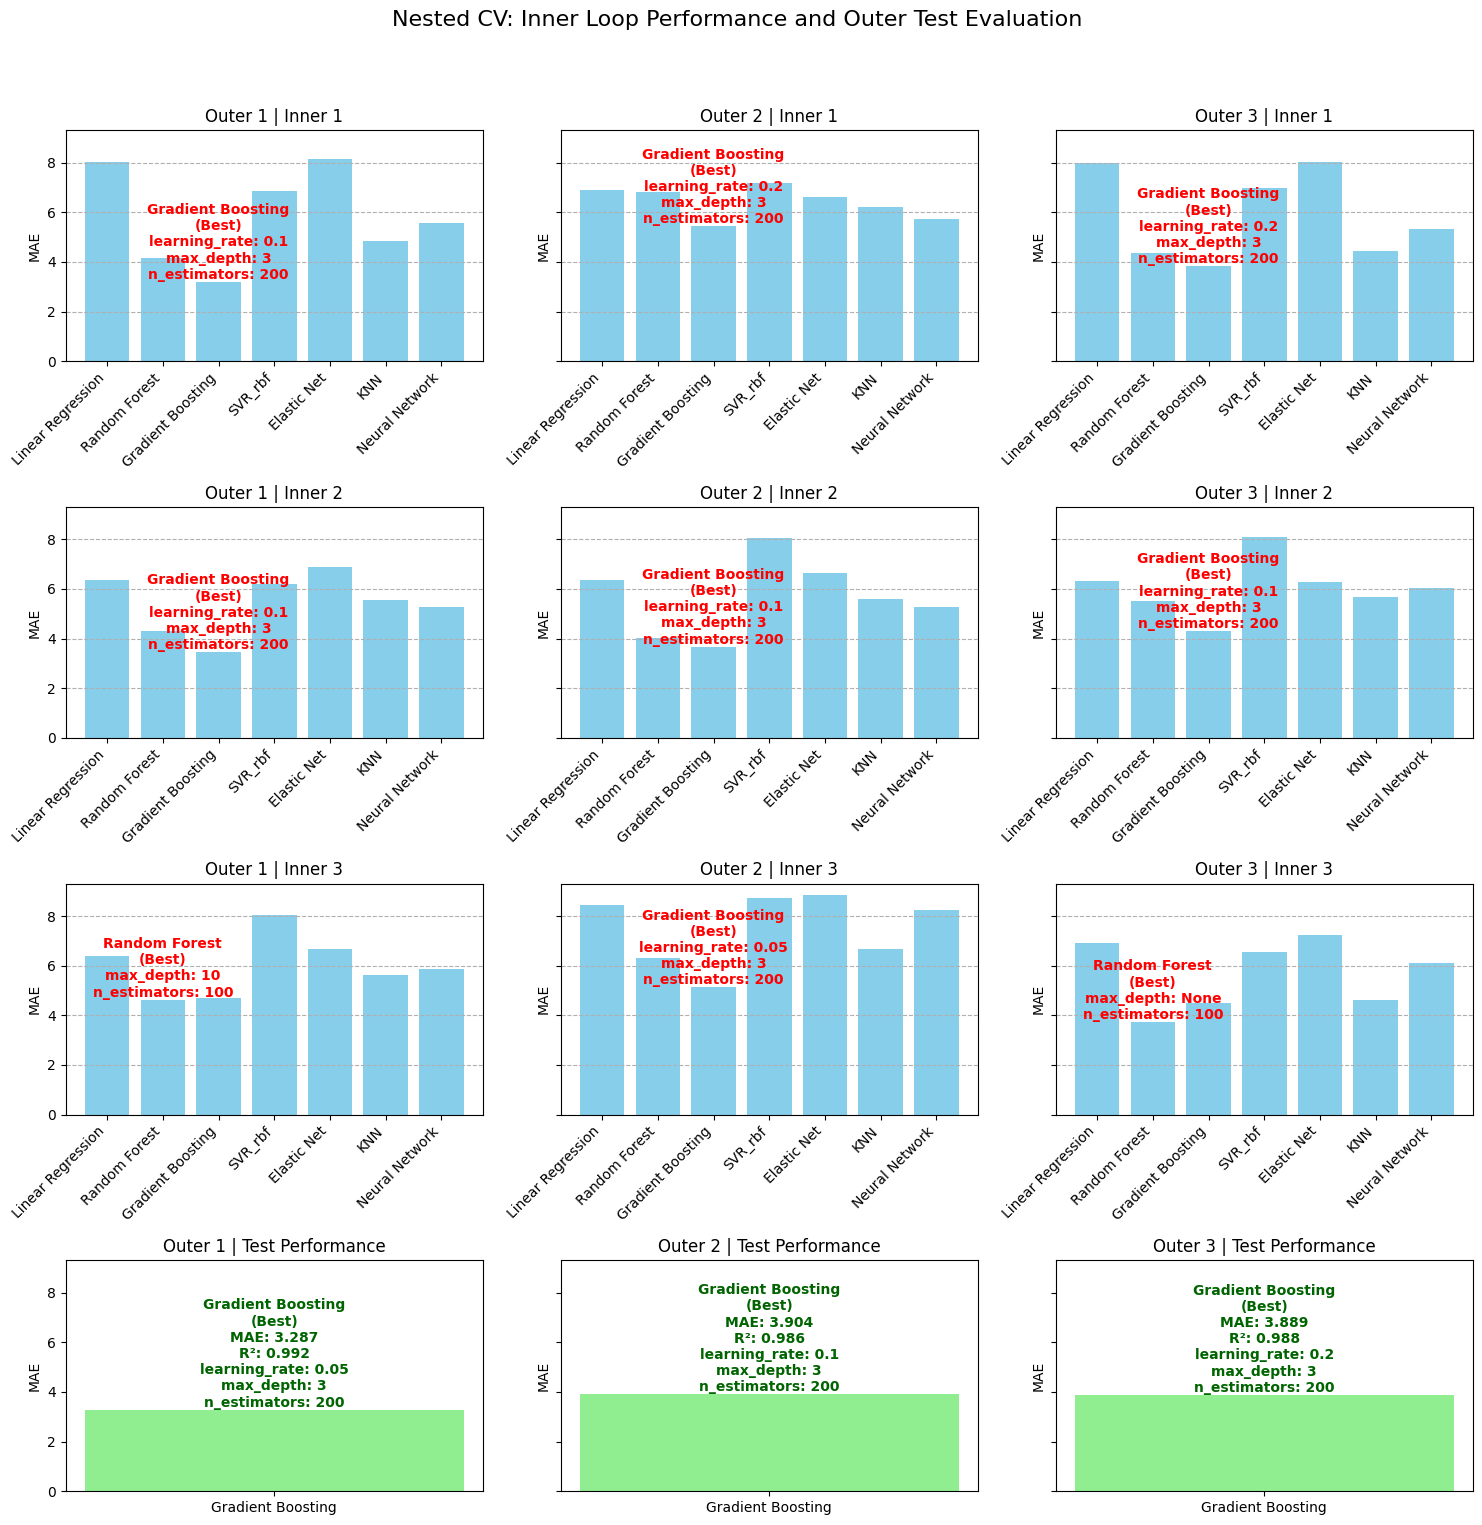

In [35]:
# --- Plotting ---
n_outer = len(nested_results)
n_inner = len(nested_results[0]["Inner_Results"])
fig, axes = plt.subplots(n_inner + 1, n_outer, figsize=(5 * n_outer, 4 * (n_inner + 1)), sharey=True)

for c, outer in enumerate(nested_results):  # columns = outer folds
    # Plot inner folds
    for r, inner in enumerate(outer["Inner_Results"]):
        ax = axes[r, c] if n_inner > 1 else axes[c]

        model_names = list(inner["Results"].keys())
        mae_scores = [inner["Results"][m]["MAE"] for m in model_names]

        bars = ax.bar(model_names, mae_scores, color="skyblue")
        ax.set_ylabel("MAE")
        ax.set_title(f"Outer {outer['Outer_Fold']} | Inner {inner['Inner_Fold']}")
        ax.set_xticklabels(model_names, rotation=45, ha="right")
        ax.grid(axis="y", linestyle="--")

        # Highlight best model
        best_model = inner["Best_Model"]
        best_params = inner["Best_Params"]
        for j, bar in enumerate(bars):
            if model_names[j] == best_model:
                param_text = "\n".join([f"{k}: {v}" for k, v in best_params.items()])
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                        f"{best_model}\n(Best)\n{param_text}",
                        va="bottom", ha="center", color="red", fontweight="bold")

    # Plot outer test set performance in last row
    ax_outer = axes[n_inner, c]
    ax_outer.bar([outer["Selected_Model"]], [outer["Outer_MAE"]], color="lightgreen")
    ax_outer.set_ylabel("MAE")
    ax_outer.set_title(f"Outer {outer['Outer_Fold']} | Test Performance")
    param_text = "\n".join([f"{k}: {v}" for k, v in outer["Selected_Params"].items()])
    ax_outer.text(0, outer["Outer_MAE"],
                  f"{outer['Selected_Model']}\n(Best)\nMAE: {outer['Outer_MAE']:.3f}\nR²: {outer['Outer_R2']:.3f}\n{param_text}",
                  va="bottom", ha="center", color="darkgreen", fontweight="bold")

fig.suptitle("Nested CV: Inner Loop Performance and Outer Test Evaluation", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()